In [2]:
from pyspark.sql import SparkSession as ss
from pyspark.sql.functions import *

In [3]:
#Initialize the Spark Session
spark = ss.builder.master("local")\
            .config("spark.sql.autoBroadcastJoinTreshold", -1)\
            .config("spark.executer.memory","500mb")\
            .appName("Exercise1")\
            .getOrCreate()

# Extract

In [4]:
#Read the source tables from Parquet format
products_table = spark.read.parquet("products_parquet")
sales_table = spark.read.parquet("sales_parquet")
sellers_table = spark.read.parquet("sellers_parquet")

In [15]:
products_table.show(5)

+----------+------------+-----+
|product_id|product_name|price|
+----------+------------+-----+
|         0|   product_0|   22|
|         1|   product_1|   30|
|         2|   product_2|   91|
|         3|   product_3|   37|
|         4|   product_4|  145|
+----------+------------+-----+
only showing top 5 rows



In [16]:
sales_table.show(5)

+--------+----------+---------+----------+---------------+--------------------+
|order_id|product_id|seller_id|      date|num_pieces_sold|       bill_raw_text|
+--------+----------+---------+----------+---------------+--------------------+
|       1|         0|        0|2020-07-10|             26|kyeibuumwlyhuwksx...|
|       2|         0|        0|2020-07-08|             13|jfyuoyfkeyqkckwbu...|
|       3|         0|        0|2020-07-05|             38|uyjihlzhzcswxcccx...|
|       4|         0|        0|2020-07-05|             56|umnxvoqbdzpbwjqmz...|
|       5|         0|        0|2020-07-05|             11|zmqexmaawmvdpqhih...|
+--------+----------+---------+----------+---------------+--------------------+
only showing top 5 rows



In [17]:
sellers_table.show()

+---------+-----------+------------+
|seller_id|seller_name|daily_target|
+---------+-----------+------------+
|        0|   seller_0|     2500000|
|        1|   seller_1|      257237|
|        2|   seller_2|      754188|
|        3|   seller_3|      310462|
|        4|   seller_4|     1532808|
|        5|   seller_5|     1199693|
|        6|   seller_6|     1055915|
|        7|   seller_7|     1946998|
|        8|   seller_8|      547320|
|        9|   seller_9|     1318051|
+---------+-----------+------------+



# Warm-up 1

- Find out how many orders, how many products and how many sellers are in the data.

In [6]:
print("Products Number: {}".format(products_table.count()))
print("Sales Numbers: {}".format(sales_table.count()))
print("Sellers Numbers: {}".format(sellers_table.count()))

Products Number: 75000000
Sales Numbers: 20000040
Sellers Numbers: 10


- How many products have been sold at least once? Which is the product contained in more orders?

As you can see, we have 75,000,000 products in our dataset and 20,000,040 orders: since each order can only have a single product, some of them have never been sold. Let’s find out how many products appear at least once and which is the product contained in more orders:

In [8]:
#How many products have been actually sold at least once?
print("Products have been sold at least onece!")
sales_table.agg(countDistinct(col("Product_id"))).show()

Products have been sold at least onece!
+-----------------+
|count(Product_id)|
+-----------------+
|           993429|
+-----------------+



In [14]:
#Which product has been sold in more than one orders?
sales_table.groupBy(col("product_id")).agg(count("*").alias("cnt")).orderBy(col("cnt").desc()).limit(3).show()

+----------+--------+
|product_id|     cnt|
+----------+--------+
|         0|19000000|
|  31136332|       3|
|  17944574|       3|
+----------+--------+



Let’s have a closer look at the second result: 19,000,000 orders out of 20 M are selling the product with product_id = 0: this is a powerful information that we should use later!

# Warm-up 2

How many distinct products have been sold in each day?

In [18]:
sales_table.groupBy(col("date")).agg(countDistinct(col("product_id")).alias("disrinctProductsSold")).orderBy(col("disrinctProductsSold").desc()).show()

+----------+--------------------+
|      date|disrinctProductsSold|
+----------+--------------------+
|2020-07-06|              100765|
|2020-07-09|              100501|
|2020-07-01|              100337|
|2020-07-03|              100017|
|2020-07-02|               99807|
|2020-07-05|               99796|
|2020-07-04|               99791|
|2020-07-07|               99756|
|2020-07-08|               99662|
|2020-07-10|               98973|
+----------+--------------------+



# Exercise 1 

What is the average revenue of the orders?


Revenue = price * quantity

In [23]:
# first join then get result
sales_table.join(products_table, sales_table["product_id"]==products_table["product_id"], "inner").agg(avg(products_table["price"]*sales_table["num_pieces_sold"])).show()

+------------------------------+
|avg((price * num_pieces_sold))|
+------------------------------+
|            1246.1338560822878|
+------------------------------+



The above is correct, and it probably works quite well (especially if you are working on a local environment)

- Note that this is not a huge problem in case you are running Spark on a local system. On a distributed environment (and with more data), though, this join could take an incredible amount of time to complete (maybe never complete at all!).

Let’s fix this issue using a technique known as “key salting”. I won’t describe in detail since I have already covered the topic in the article linked above. As a summary, what we are going to do is the following:

1. Duplicate the entries that we have in the dimension table for the most common products, e.g. product_0 will be replicated creating the IDs: product_0–1, product_0–2, product_0–3 and so on.
2. On the sales table, we are going to replace “product_0” with a random replica (e.g. some of them will be replaced with product_0–1, others with product_0–2, etc.) Using the new “salted” key will un-skew the join:


The important thing to observe here is that we are NOT salting ALL the products, but only those that drive skewness (in the example we are getting the 100 most frequent products). Salting the whole dataset would be problematic since the number of rows would grow linearly on the “salting factor”:

In [ ]:
"""# Step 1 - Check and select the skewed keys 
# In this case we are retrieving the top 100 keys: these will be the only salted keys.
results = sales_table.groupby(sales_table["product_id"]).count().sort(col("count").desc()).limit(100).collect()

# Step 2 - What we want to do is:
#  a. Duplicate the entries that we have in the dimension table for the most common products, e.g.
#       product_0 will become: product_0-1, product_0-2, product_0-3 and so on
#  b. On the sales table, we are going to replace "product_0" with a random duplicate (e.g. some of them 
#     will be replaced with product_0-1, others with product_0-2, etc.)
# Using the new "salted" key will unskew the join

# Let's create a dataset to do the trick
REPLICATION_FACTOR = 101
l = []
replicated_products = []
for _r in results:
    replicated_products.append(_r["product_id"])
    for _rep in range(0, REPLICATION_FACTOR):
        l.append((_r["product_id"], _rep))
rdd = spark.sparkContext.parallelize(l)
replicated_df = rdd.map(lambda x: Row(product_id=x[0], replication=int(x[1])))
replicated_df = spark.createDataFrame(replicated_df)

#   Step 3: Generate the salted key
products_table = products_table.join(broadcast(replicated_df),
                                     products_table["product_id"] == replicated_df["product_id"], "left"). \
    withColumn("salted_join_key", when(replicated_df["replication"].isNull(), products_table["product_id"]).otherwise(
    concat(replicated_df["product_id"], lit("-"), replicated_df["replication"])))

sales_table = sales_table.withColumn("salted_join_key", when(sales_table["product_id"].isin(replicated_products),
                                                             concat(sales_table["product_id"], lit("-"),
                                                                    round(rand() * (REPLICATION_FACTOR - 1), 0).cast(
                                                                        IntegerType()))).otherwise(
    sales_table["product_id"]))

#   Step 4: Finally let's do the join
print(sales_table.join(products_table, sales_table["salted_join_key"] == products_table["salted_join_key"],
                       "inner").
      agg(avg(products_table["price"] * sales_table["num_pieces_sold"])).show())

print("Ok")"""

# !!!
Using this technique in a local environment could lead to an increase of the execution time; in the real world, though, this trick can make the difference between completing and not completing the join.

# Some Notes About Joning in Spark:

Sticking to use cases mentioned above, Spark will perform (or be forced by us to perform) joins in two different ways: either using Sort Merge Joins if we are joining two big tables, or Broadcast Joins if at least one of the datasets involved is small enough to be stored in the memory of the single all executors. Note that there are other types of joins (e.g. Shuffle Hash Joins), but those mentioned earlier are the most common, in particular from Spark 2.3.

                                                    SORT MERGE JOINS
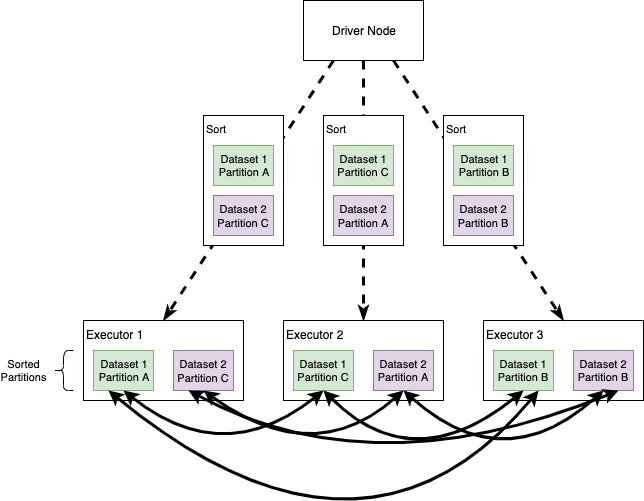
In a Sort Merge Join partitions are sorted on the join key prior to the join operation.


---
                                                    BROADCAST JOINS
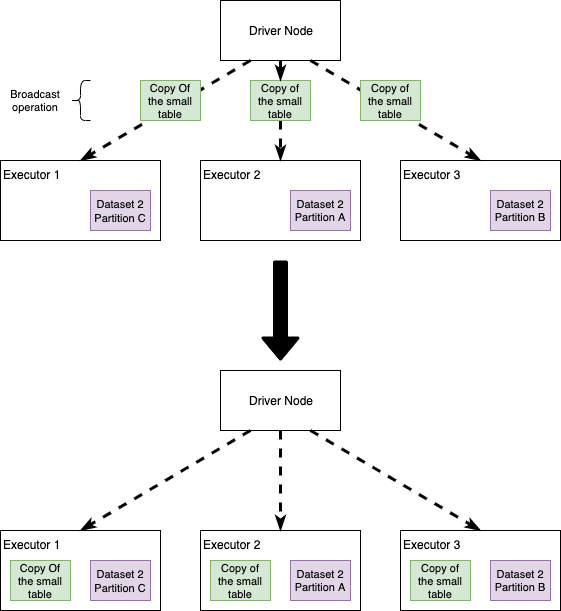
In a Broadcast Join a copy of the small table is sent to all the Executors. Each executor will then perform the join without the need of network communication


---

Is broadcasting always good for performance? Not at all! If you try to execute the snippets above giving more resources to the cluster (in particular more executors), the non-broadcast version will run faster than the broadcast one! One reason why this happens is because the broadcasting operation is itself quite expensive (it means that all the nodes need to receive a copy of the table), so it’s not surprising that if we increase the amount of executors that need to receive the table, we increase the broadcasting cost, which suddenly may become higher than the join cost itself.

---

## Takeaways
* Joins can be difficult to tune since performance are bound to both the code and the Spark configuration (number of executors, memory, etc.)
* Some of the most common issues with joins are all-to-all communication between the nodes and data skewness
* We can avoid all-to-all communication using broadcasting of small tables or of medium-sized tables if we have enough memory in the cluster
* Broadcasting is not always beneficial to performance: we need to have an eye for the Spark config
* Broadcasting can make the code unstable if broadcast tables grow through time
* Skewness leads to an uneven workload on the cluster, resulting in a very small subset of tasks to take much longer than the average
* There are multiple ways to fight skewness, one is repartitioning.
* We can create our own repartitioning key, e.g. using the key salting technique

For more inf: https://towardsdatascience.com/the-art-of-joining-in-spark-dcbd33d693c


# Exercise 2


For each seller, what is the average % contribution of an order to the seller's daily quota?

#Example
If Seller_0 with `quota=250` has 3 orders:

Order 1: 10 products sold

Order 2: 8 products sold

Order 3: 7 products sold

The average % contribution of orders to the seller's quota would be:

Order 1: 10/105 = 0.04

Order 2: 8/105 = 0.032

Order 3: 7/105 = 0.028

Average % Contribution = (0.04+0.032+0.028)/3 = 0.03333




---

Again, this could generate a skewed join, since even the sellers are not evenly distributed. In this case, though, the solution is much simpler! Since the sellers table is very small, we can broadcast it, making the operations much much faster!


“Broadcasting” simply means that a copy of the table is sent to every executor, allowing to “localize” the task. We need to use this operator carefully: when we broadcast a table, we need to be sure that this will not become too-big-to-broadcast in the future, otherwise we’ll start to have Out Of Memory errors later in time (as the broadcast dataset gets bigger).

In [26]:
#Initialize the Spark Session
spark = ss.builder.master("local")\
            .config("spark.sql.autoBroadcastJoinTreshold", -1)\
            .config("spark.executer.memory","3g")\
            .appName("Exercise1")\
            .getOrCreate()

In [27]:
#Read the source tables from Parquet format
products_table = spark.read.parquet("products_parquet")
sales_table = spark.read.parquet("sales_parquet")
sellers_table = spark.read.parquet("sellers_parquet")

In [33]:
#   Wrong way to do this - Skewed 
#   (Note that Spark will probably broadcast the table anyway, unless we forbid it throug the configuration paramters)
sales_table.join(sellers_table, sales_table["seller_id"]==sellers_table["seller_id"], "inner").withColumn(
    "ratio", sales_table["num_pieces_sold"]/sellers_table["daily_target"]).groupBy(
    sales_table["seller_id"]).agg(avg("ratio")).show()

+---------+--------------------+
|seller_id|          avg(ratio)|
+---------+--------------------+
|        7|2.595228787788170...|
|        3| 1.62888537056594E-4|
|        8|9.213030375408861E-5|
|        0|2.019885898946922...|
|        5|4.211073965904022E-5|
|        6|4.782147194369122E-5|
|        9|3.837913136180238E-5|
|        1|1.964233366461014...|
|        4|3.296428039825817E-5|
|        2|6.690408001060484E-5|
+---------+--------------------+



In [30]:
#   Correct way through broarcasting (all the time broadcast small data)
sales_table.join(broadcast(sellers_table), sales_table["seller_id"]==sellers_table["seller_id"], "inner").withColumn(
    "ratio", sales_table["num_pieces_sold"]/sellers_table["daily_target"]).groupBy(
    sales_table["seller_id"]).agg(avg("ratio")).show()

+---------+--------------------+
|seller_id|          avg(ratio)|
+---------+--------------------+
|        7|2.595228787788170...|
|        3| 1.62888537056594E-4|
|        8|9.213030375408861E-5|
|        0|2.019885898946922...|
|        5|4.211073965904022E-5|
|        6|4.782147194369122E-5|
|        9|3.837913136180238E-5|
|        1|1.964233366461014...|
|        4|3.296428039825817E-5|
|        2|6.690408001060484E-5|
+---------+--------------------+



# Exercise 3

Who are the second most selling and the least selling persons (sellers) for each product? Who are those for product with `product_id = 0`


This sounds like window functions! Let’s analyze the question: for each product, we need the second most selling and the least selling employees (sellers): we are probably going to need two rankings, one to get the second and the other one to get the last in the sales chart. We also need to handle some edge cases:


* If a product has been sold by only one seller, we’ll put it into a special category (category: Only seller or multiple sellers with the same quantity).
* If a product has been sold by more than one seller, but all of them sold the same quantity, we are going to put them in the same category as if they were only a single seller for that product (category: Only seller or multiple sellers with the same quantity).
* If the “least selling” is also the “second selling”, we will count it only as “second seller”


Let’s draft a strategy:


1. We get the sum of sales for each product and seller pairs.
2. We add two new ranking columns: one that ranks the products’ sales in descending order and another one that ranks in ascending order.
3. We split the dataset obtained in three pieces: one for each case that we want to handle (second top selling, least selling, single selling).
4. When calculating the “least selling”, we exclude those products that have a single seller and those where the least selling employee is also the second most selling
5. We merge the pieces back together.

In [35]:
# Calcuate the number of pieces sold by each seller for each product
sales_table = sales_table.groupby(col("product_id"), col("seller_id")). \
    agg(sum("num_pieces_sold").alias("num_pieces_sold"))
sales_table.show(5)

+----------+---------+---------------+
|product_id|seller_id|num_pieces_sold|
+----------+---------+---------------+
|  46681458|        9|           33.0|
|  16712495|        9|            9.0|
|  51262311|        5|           57.0|
|   8370729|        6|           11.0|
|  64958710|        5|           93.0|
+----------+---------+---------------+
only showing top 5 rows



In [40]:
# Create the window functions, one will sort ascending the other one descending. Partition by the product_id
# and sort by the pieces sold
from pyspark.sql.window import Window

window_desc = Window.partitionBy(col("product_id")).orderBy(col("num_pieces_sold").desc())
window_asc = Window.partitionBy(col("product_id")).orderBy(col("num_pieces_sold").asc())

In [41]:
# Create a Dense Rank (to avoid holes)
sales_table = sales_table.withColumn("rank_asc", dense_rank().over(window_asc)). \
    withColumn("rank_desc", dense_rank().over(window_desc))

sales_table.show(5)

+----------+---------+---------------+--------+---------+
|product_id|seller_id|num_pieces_sold|rank_asc|rank_desc|
+----------+---------+---------------+--------+---------+
|  10005243|        6|           98.0|       1|        1|
|  10023464|        9|           59.0|       1|        1|
|  10050363|        6|           18.0|       1|        1|
|  10089524|        2|           53.0|       1|        1|
|  10122266|        2|           25.0|       1|        1|
|  10134574|        3|           28.0|       1|        1|
|  10150439|        4|           72.0|       1|        1|
|  10158822|        9|           86.0|       1|        1|
|  10160884|        7|           89.0|       1|        1|
|  10172594|        2|           60.0|       1|        1|
|  10175294|        7|           29.0|       1|        1|
|   1017716|        9|           82.0|       1|        1|
|  10200802|        2|           42.0|       1|        1|
|  10215353|        1|           22.0|       1|        1|
|  10218345|  

In [42]:
# Get products that only have one row OR the products in which multiple sellers sold the same amount
# (i.e. all the employees that ever sold the product, sold the same exact amount)
single_seller = sales_table.where(col("rank_asc") == col("rank_desc")).select(
    col("product_id").alias("single_seller_product_id"), col("seller_id").alias("single_seller_seller_id"),
    lit("Only seller or multiple sellers with the same results").alias("type")
)

single_seller.show(5)

+------------------------+-----------------------+--------------------+
|single_seller_product_id|single_seller_seller_id|                type|
+------------------------+-----------------------+--------------------+
|                10005243|                      6|Only seller or mu...|
|                10023464|                      9|Only seller or mu...|
|                10050363|                      6|Only seller or mu...|
|                10089524|                      2|Only seller or mu...|
|                10122266|                      2|Only seller or mu...|
+------------------------+-----------------------+--------------------+
only showing top 5 rows



In [43]:
# Get the second top sellers
second_seller = sales_table.where(col("rank_desc") == 2).select(
    col("product_id").alias("second_seller_product_id"), col("seller_id").alias("second_seller_seller_id"),
    lit("Second top seller").alias("type")
)

second_seller.show(5)

+------------------------+-----------------------+-----------------+
|second_seller_product_id|second_seller_seller_id|             type|
+------------------------+-----------------------+-----------------+
|                12194170|                      3|Second top seller|
|                14700981|                      1|Second top seller|
|                16113262|                      7|Second top seller|
|                17806195|                      5|Second top seller|
|                19121475|                      3|Second top seller|
+------------------------+-----------------------+-----------------+
only showing top 5 rows



In [44]:
# Get the least sellers and exclude those rows that are already included in the first piece
# We also exclude the "second top sellers" that are also "least sellers"
least_seller = sales_table.where(col("rank_asc") == 1).select(
    col("product_id"), col("seller_id"),
    lit("Least Seller").alias("type")
).join(single_seller, (sales_table["seller_id"] == single_seller["single_seller_seller_id"]) & (
        sales_table["product_id"] == single_seller["single_seller_product_id"]), "left_anti"). \
    join(second_seller, (sales_table["seller_id"] == second_seller["second_seller_seller_id"]) & (
        sales_table["product_id"] == second_seller["second_seller_product_id"]), "left_anti")

least_seller.show()

+----------+---------+------------+
|product_id|seller_id|        type|
+----------+---------+------------+
|  19986717|        1|Least Seller|
|  40496308|        5|Least Seller|
|  52606213|        7|Least Seller|
|  14542470|        5|Least Seller|
|  28592106|        5|Least Seller|
|  17944574|        8|Least Seller|
|  61475460|        7|Least Seller|
|   3534470|        3|Least Seller|
|  35669461|        4|Least Seller|
|  32602520|        9|Least Seller|
|  72017876|        1|Least Seller|
|  67723231|        5|Least Seller|
|  56011040|        5|Least Seller|
|  34681047|        5|Least Seller|
|  57735075|        9|Least Seller|
|  18182299|        7|Least Seller|
|  69790381|        5|Least Seller|
|  31136332|        9|Least Seller|
|  10978356|        7|Least Seller|
|  20774718|        9|Least Seller|
+----------+---------+------------+
only showing top 20 rows



In [45]:
# Union all the pieces
union_table = least_seller.select(
    col("product_id"),
    col("seller_id"),
    col("type")
).union(second_seller.select(
    col("second_seller_product_id").alias("product_id"),
    col("second_seller_seller_id").alias("seller_id"),
    col("type")
)).union(single_seller.select(
    col("single_seller_product_id").alias("product_id"),
    col("single_seller_seller_id").alias("seller_id"),
    col("type")
))
union_table.show()

# Which are the second top seller and least seller of product 0?
union_table.where(col("product_id") == 0).show()

+----------+---------+------------+
|product_id|seller_id|        type|
+----------+---------+------------+
|  19986717|        1|Least Seller|
|  40496308|        5|Least Seller|
|  52606213|        7|Least Seller|
|  14542470|        5|Least Seller|
|  28592106|        5|Least Seller|
|  17944574|        8|Least Seller|
|  61475460|        7|Least Seller|
|   3534470|        3|Least Seller|
|  35669461|        4|Least Seller|
|  32602520|        9|Least Seller|
|  72017876|        1|Least Seller|
|  67723231|        5|Least Seller|
|  56011040|        5|Least Seller|
|  34681047|        5|Least Seller|
|  57735075|        9|Least Seller|
|  18182299|        7|Least Seller|
|  69790381|        5|Least Seller|
|  31136332|        9|Least Seller|
|  10978356|        7|Least Seller|
|  20774718|        9|Least Seller|
+----------+---------+------------+
only showing top 20 rows

+----------+---------+--------------------+
|product_id|seller_id|                type|
+----------+---------+

# Exercise 4

Create a new column called "hashed_bill" defined as follows:

- if the order_id is even: apply MD5 hashing iteratively to the bill_raw_text field, once for each 'A' (capital 'A') present in the text. E.g. if the bill text is 'nbAAnllA', you would apply hashing three times iteratively (only if the order number is even)
- if the order_id is odd: apply SHA256 hashing to the bill text


Finally, check if there are any duplicate on the new column


For this final exercise, we simply need to apply a fancy algorithm. We can do that through UDFs (User Defined Functions). A UDF is a custom function that can be invoked on datafarmes columns; as a rule of thumb, we should usually try to avoid UDFs, since Spark is not really capable to optimize them: UDF code usually runs slower than the non-UDF counterpart. Unfortunately, we cannot apply the algorithm described just using Spark SQL functions.

In [47]:
#   Init spark session
spark = SparkSession.builder \
    .master("local") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.executor.memory", "1g") \
    .appName("Exercise1") \
    .getOrCreate()

#   Load source data
products_table = spark.read.parquet("products_parquet")
sales_table = spark.read.parquet("sales_parquet")
sellers_table = spark.read.parquet("sellers_parquet")

In [54]:
#   Define the UDF function
def algo(order_id, bill_text):
    #   If number is even
    ret = bill_text.encode("utf-8")
    if int(order_id) % 2 == 0:
        #   Count number of 'A'
        cnt_A = bill_text.count("A")
        for _c in range(0, cnt_A):
            ret = hashlib.md5(ret).hexdigest().encode("utf-8")
        ret = ret.decode('utf-8')
    else:
        ret = hashlib.sha256(ret).hexdigest()
    return ret

#   Register the UDF function.

In [55]:
algo_udf = spark.udf.register("algo", algo)

In [ ]:
#   Use the `algo_udf` to apply the aglorithm and then check if there is any duplicate hash in the table
sales_table.withColumn("hashed_bill", algo_udf(col("order_id"), col("bill_raw_text")))\
    .groupby(col("hashed_bill")).agg(count("*").alias("cnt")).where(col("cnt") > 1).show()


First, we need to define the UDF function: def algo(order_id, bill_text). The algo function receives the order_id and the bill_text as input.

The UDF function implements the algorithm:

1. Check if the order_id is even or odd.
2. If order_id is even, count the number of capital ‘A’ in the bill text and iteratively apply MD5
3. If order_id is odd, apply SHA256
4. Return the hashed string


Afterward, this function needs to be registered in the Spark Session through the line algo_udf = spark.udf.register(“algo”, algo). The first parameter is the name of the function within the Spark context while the second parameter is the actual function that will be executed.

We apply the UDF at the following line:

sales_table.withColumn("hashed_bill", algo_udf(col("order_id"), col("bill_raw_text")))
As you can see, the function takes two columns as input and it will be executed for each row (i.e. for each pair of order_id and bill_raw_text).

In the final dataset, all the hashes should be different, so the query should return an empty dataset

## Take Away

If you completed all the exercises, congratulations! Those covered some very important topics about Spark SQL development:

1. Joins Skewness: This is usually the main pain point in Spark pipelines; sometimes it is very difficult to solve, because it’s not easy to find a balance among all the factors that are involved in these operations.
2. Window functions: Super useful, the only thing to remember is to first define the windowing.
3. UDFs: Although they are very helpful, we should think twice before jumping into the development of such functions, since their execution might slow down our code.


Help Source: https://towardsdatascience.com/six-spark-exercises-to-rule-them-all-242445b24565
